# Import

In [1]:
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
import tensorflow_addons as tfa

from tqdm.notebook import tqdm

print(tf.__version__, tfa.__version__)

2.8.4 0.18.0


In [2]:
!which python

/opt/conda/bin/python


In [3]:
sys.path.append("..")
from generative_models import ddpm

## Load & build Cifar 10 dataset
See https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data for details about loading and labels

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [5]:
x_train, x_test = tf.cast(x_train, dtype=tf.float32), tf.cast(x_test, dtype=tf.float32)
y_train, y_test = tf.squeeze(y_train), tf.squeeze(y_test)

print(
    x_train.shape,
    x_test.shape,
    y_train.shape,
    y_test.shape,
    sep="\n"
)

2023-03-26 13:06:25.643168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 13:06:25.812958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 13:06:25.814883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 13:06:25.820467: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000,)
(10000,)


Following https://keras.io/examples/generative/ddpm/#dataset:

In [6]:
def train_preprocessing(img):
    # Rescale the pixel values between -1 and 1
    img = img / 127.5 - 1.0
    img = tf.clip_by_value(img, -1.0, 1.0)
    
    # Flips an image left/right randomly.
    img = tf.image.random_flip_left_right(img)
    return img


train_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(
        lambda x, y: (train_preprocessing(x), y), 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size=16) # 128
    .shuffle(buffer_size=64)
    .prefetch(tf.data.AUTOTUNE)
)

In [7]:
data = next(iter(train_dataset))
data[0].shape, data[1].shape

(TensorShape([16, 32, 32, 3]), TensorShape([16]))

tf.Tensor(2, shape=(), dtype=uint8)


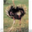

In [8]:
print(data[1][0])
tf.keras.preprocessing.image.array_to_img(data[0][0], data_format="channels_last")

In [9]:
class_mapping = { # See: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

# Define Diffusion Model

In [10]:
diffuser = ddpm.unet.DiffusionUNet(
    image_shape=(32, 32, 3),
    class_conditioning=True,
    n_classes=10,
    hidden_units=128,
    n_residual_blocks=2,
    attention_resolutions=(16,),
    channels_multipliers=(1, 2, 2, 2),
    output_channel=3,
    groups=32
)

Get U-Net layers:

In [11]:
# class-conditioned U-Net
for i, layer in enumerate(diffuser.layers):
    print(f"{i}: {layer.name}")

0: lambda
1: step_block
2: class_embedding
3: downsampler_conv_0
4: downsampler_0_ch128_resblock0
5: downsampler_0_ch128_resblock1
6: downsampler_0_ch128_downsample
7: downsampler_1_ch256_resblock0
8: downsampler_1_ch256_attention_block0
9: downsampler_1_ch256_resblock1
10: downsampler_1_ch256_attention_block1
11: downsampler_1_ch256_downsample
12: downsampler_2_ch256_resblock0
13: downsampler_2_ch256_resblock1
14: downsampler_2_ch256_downsample
15: downsampler_3_ch256_resblock0
16: downsampler_3_ch256_resblock1
17: middle_residual_block1
18: middle_attention
19: middle_residual_block2
20: upsampler_3_ch256_resblock0
21: upsampler_3_ch256_resblock1
22: upsampler_3_ch256_resblock2
23: upsampler_3_ch256_upsample
24: upsampler_2_ch256_resblock0
25: upsampler_2_ch256_resblock1
26: upsampler_2_ch256_resblock2
27: upsampler_2_ch256_upsample
28: upsampler_1_ch256_resblock0
29: upsampler_1_ch256_attention_block0
30: upsampler_1_ch256_resblock1
31: upsampler_1_ch256_attention_block1
32: upsampl

2023-03-26 13:06:50.769673: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


1000/1000 [==============================] - 203s 196ms/step


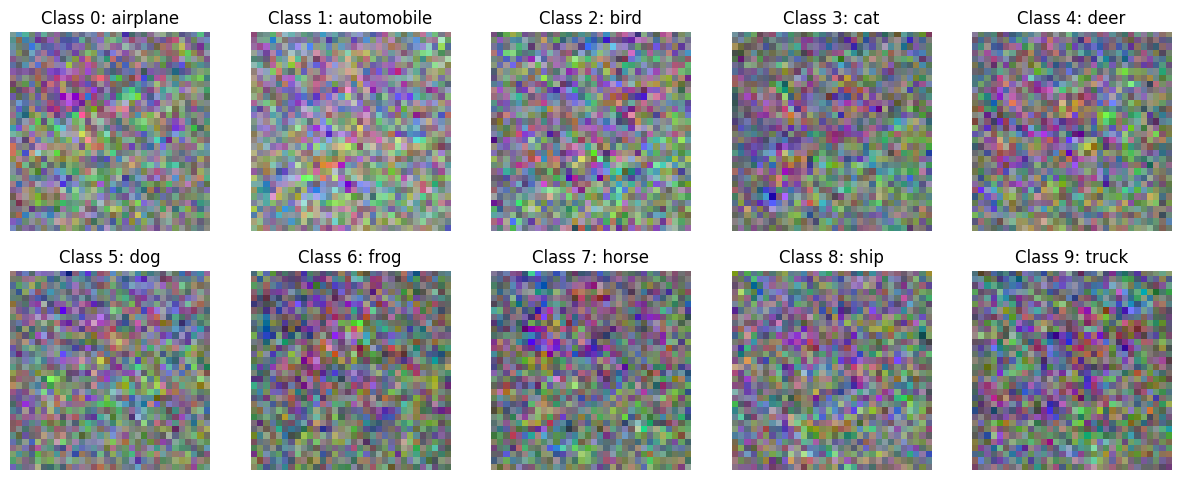

In [12]:
images = diffuser.generative_process(
    sampling_size=10, label=tf.range(10), output_trajectory=False, verbose=1
)

fig = plt.figure(figsize=(5 * 3, 5 * 3))

for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title(f"Class {i}: {class_mapping[i]}")
    plt.imshow(
        tf.keras.preprocessing.image.array_to_img(
            images[i], data_format="channels_last"
        )
    )
    plt.axis("off")
plt.show()

Load previous checkpoint weights

In [13]:
diffuser.load_weights(
    os.path.join(
        "/home/jupyter/instance_registry",
        "cifar10_diffuser",
        "ckpt_1_weights.65-0.03.hdf5",
    )
)

1000/1000 [==============================] - 194s 194ms/step


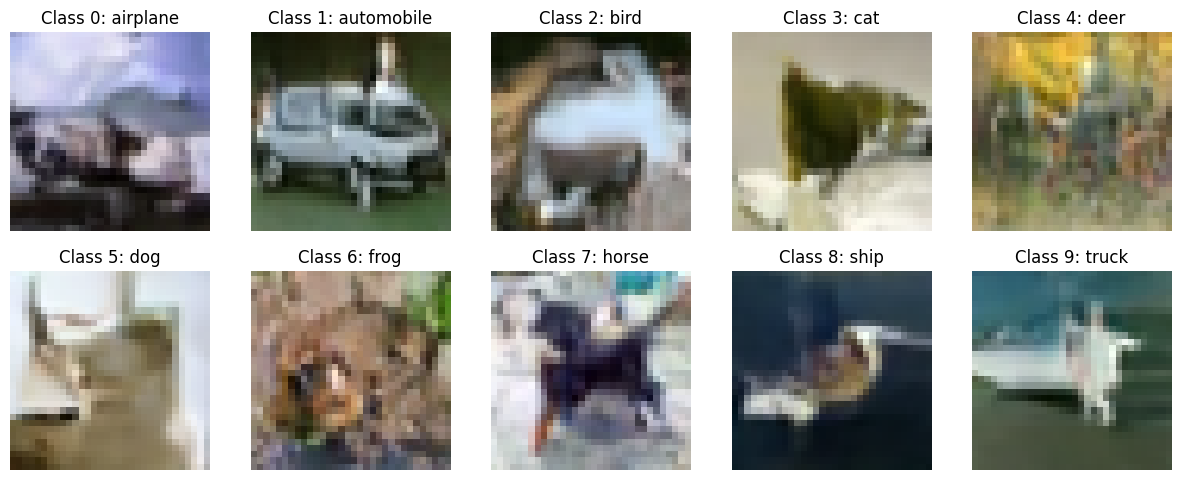

In [14]:
images = diffuser.generative_process(
    sampling_size=10, label=tf.range(10), output_trajectory=False, verbose=1
)

fig = plt.figure(figsize=(5 * 3, 5 * 3))

for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title(f"Class {i}: {class_mapping[i]}")
    plt.imshow(
        tf.keras.preprocessing.image.array_to_img(
            images[i], data_format="channels_last"
        )
    )
    plt.axis("off")
plt.show()

See https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam for Exponential Moving Average

In [15]:
diffuser.compile(    
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 2e-5
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

# Train Diffusion Model

In [16]:
DATASET_SIZE = x_train.shape[0]
BATCH_SIZE = 16 # 128
STEPS_PER_EPOCH = int(np.ceil(DATASET_SIZE/BATCH_SIZE))

In [17]:
DATASET_SIZE, BATCH_SIZE, STEPS_PER_EPOCH

(50000, 16, 3125)

In [18]:
instance_registry = "/home/jupyter/instance_registry"
diffuser_folder = "cifar10_diffuser"
filename = "ckpt_1_weights.{epoch:02d}-{loss:.2f}.hdf5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(instance_registry, diffuser_folder, filename),
    monitor="loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
)

synthesis_callback = ddpm.callbacks.DiffusionSynthesisCallback(
    image_rows=2, 
    image_cols=3, 
    image_width=2, 
    image_height=2, 
    epoch_interval=4, 
    verbose=1
)

In [19]:
diffuser.summary()

Model: "diffusion_u_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             multiple                  0         
                                                                 
 step_block (Sequential)     (10, 512)                 328704    
                                                                 
 class_embedding (Embedding)  multiple                 1280      
                                                                 
 downsampler_conv_0 (Conv2D)  multiple                 3584      
                                                                 
 downsampler_0_ch128_resbloc  multiple                 361344    
 k0 (ResBlock)                                                   
                                                                 
 downsampler_0_ch128_resbloc  multiple                 361344    
 k1 (ResBlock)                                     

Epoch 66/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0960
Epoch 66: loss improved from inf to 0.03168, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.66-0.03.hdf5
3125/3125 [==============================] - 720s 222ms/step - loss: 0.0317 - mean_absolute_error: 0.0960
Epoch 67/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0956
Epoch 67: loss improved from 0.03168 to 0.03128, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.67-0.03.hdf5
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0313 - mean_absolute_error: 0.0956
Epoch 68/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0953
Epoch 68: loss did not improve from 0.03128
3125/3125 [==============================] - 690s 221ms/step - loss: 0.0313 - mean_absolute_error: 0.0953
Epoch 69/200
3125/3125 [=

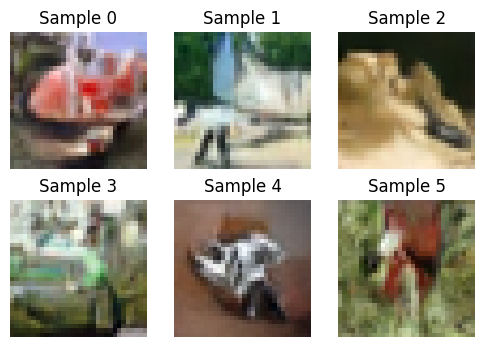

3125/3125 [==============================] - 872s 279ms/step - loss: 0.0314 - mean_absolute_error: 0.0957
Epoch 70/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0957
Epoch 70: loss did not improve from 0.03128
3125/3125 [==============================] - 691s 221ms/step - loss: 0.0316 - mean_absolute_error: 0.0957
Epoch 71/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0310 - mean_absolute_error: 0.0953
Epoch 71: loss improved from 0.03128 to 0.03097, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.71-0.03.hdf5
3125/3125 [==============================] - 691s 221ms/step - loss: 0.0310 - mean_absolute_error: 0.0953
Epoch 72/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0956
Epoch 72: loss did not improve from 0.03097
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0313 - mean_absolute_error: 0.0956
Epoch 73/200


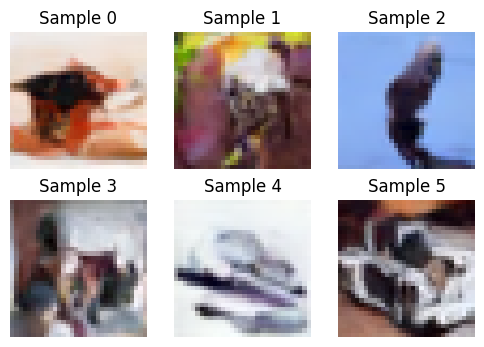

3125/3125 [==============================] - 874s 280ms/step - loss: 0.0314 - mean_absolute_error: 0.0955
Epoch 74/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0957
Epoch 74: loss did not improve from 0.03097
3125/3125 [==============================] - 694s 222ms/step - loss: 0.0313 - mean_absolute_error: 0.0957
Epoch 75/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.0956
Epoch 75: loss did not improve from 0.03097
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0315 - mean_absolute_error: 0.0956
Epoch 76/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0955
Epoch 77: loss did not improve from 0.03097

Epoch 77: generating 6 samples with labels [9 3 2 1 1 8]
1000/1000 [==============================] - 181s 180ms/step


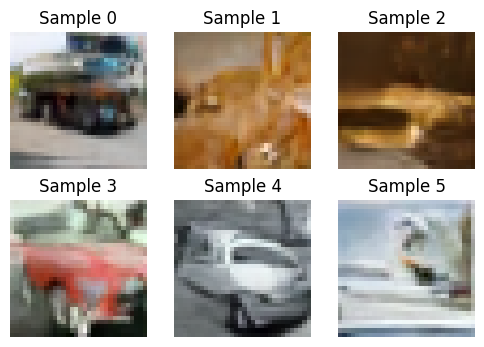

3125/3125 [==============================] - 873s 279ms/step - loss: 0.0313 - mean_absolute_error: 0.0955
Epoch 78/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0310 - mean_absolute_error: 0.0947
Epoch 78: loss did not improve from 0.03097
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0310 - mean_absolute_error: 0.0947
Epoch 79/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0957
Epoch 79: loss did not improve from 0.03097
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0316 - mean_absolute_error: 0.0957
Epoch 80/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.0957
Epoch 80: loss did not improve from 0.03097
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0315 - mean_absolute_error: 0.0957
Epoch 81/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0956


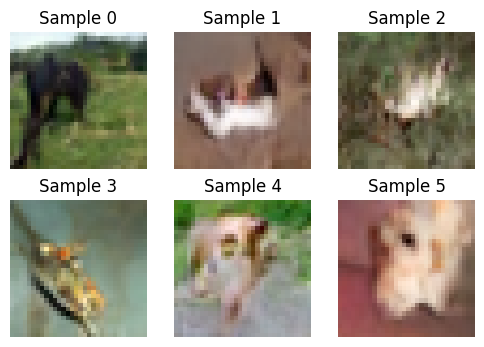

3125/3125 [==============================] - 874s 280ms/step - loss: 0.0316 - mean_absolute_error: 0.0956
Epoch 82/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0956
Epoch 82: loss did not improve from 0.03097
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0317 - mean_absolute_error: 0.0956
Epoch 83/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0955
Epoch 83: loss did not improve from 0.03097
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0314 - mean_absolute_error: 0.0955
Epoch 84/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.0948
Epoch 84: loss did not improve from 0.03097
3125/3125 [==============================] - 692s 222ms/step - loss: 0.0311 - mean_absolute_error: 0.0948
Epoch 85/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0949


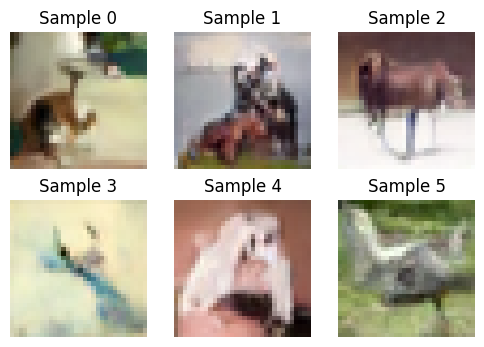

3125/3125 [==============================] - 873s 279ms/step - loss: 0.0314 - mean_absolute_error: 0.0949
Epoch 86/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0946
Epoch 86: loss improved from 0.03097 to 0.03091, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.86-0.03.hdf5
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0309 - mean_absolute_error: 0.0946
Epoch 87/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0950
Epoch 87: loss did not improve from 0.03091
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0313 - mean_absolute_error: 0.0950
Epoch 88/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0951
Epoch 88: loss improved from 0.03091 to 0.03090, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.88-0.03.hdf5
3125/3125 [==========

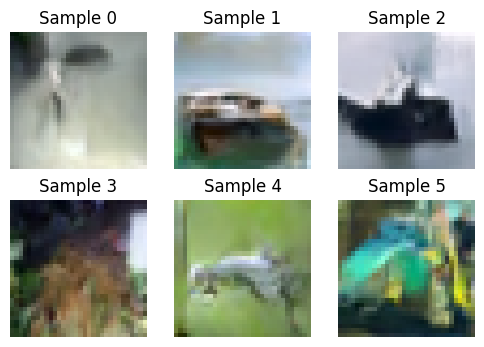

3125/3125 [==============================] - 868s 278ms/step - loss: 0.0312 - mean_absolute_error: 0.0949
Epoch 90/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.0946
Epoch 90: loss improved from 0.03090 to 0.03081, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.90-0.03.hdf5
3125/3125 [==============================] - 689s 220ms/step - loss: 0.0308 - mean_absolute_error: 0.0946
Epoch 91/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0947
Epoch 91: loss did not improve from 0.03081
3125/3125 [==============================] - 688s 220ms/step - loss: 0.0309 - mean_absolute_error: 0.0947
Epoch 92/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.0943
Epoch 92: loss improved from 0.03081 to 0.03069, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.92-0.03.hdf5
3125/3125 [==========

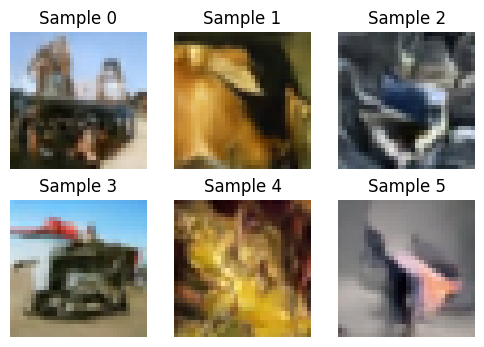

3125/3125 [==============================] - 866s 277ms/step - loss: 0.0313 - mean_absolute_error: 0.0951
Epoch 94/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.0940
Epoch 94: loss improved from 0.03069 to 0.03060, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.94-0.03.hdf5
3125/3125 [==============================] - 690s 221ms/step - loss: 0.0306 - mean_absolute_error: 0.0940
Epoch 95/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0953
Epoch 95: loss did not improve from 0.03060
3125/3125 [==============================] - 691s 221ms/step - loss: 0.0314 - mean_absolute_error: 0.0953
Epoch 96/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.0941
Epoch 96: loss did not improve from 0.03060
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0308 - mean_absolute_error: 0.0941
Epoch 97/200


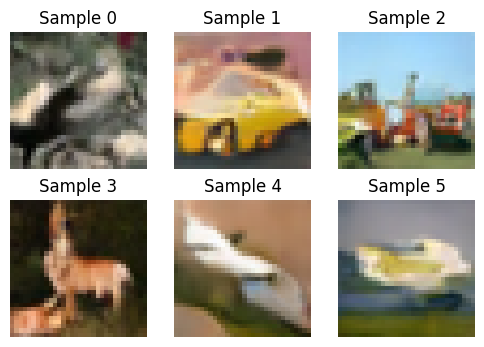

3125/3125 [==============================] - 878s 281ms/step - loss: 0.0306 - mean_absolute_error: 0.0941
Epoch 98/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0943
Epoch 98: loss did not improve from 0.03060
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0309 - mean_absolute_error: 0.0943
Epoch 99/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0946
Epoch 99: loss did not improve from 0.03060
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0309 - mean_absolute_error: 0.0946
Epoch 100/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.0946
Epoch 100: loss did not improve from 0.03060
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0311 - mean_absolute_error: 0.0946
Epoch 101/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.09

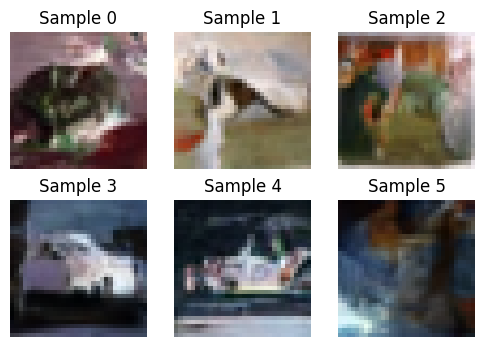

3125/3125 [==============================] - 874s 280ms/step - loss: 0.0308 - mean_absolute_error: 0.0944
Epoch 102/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.0947
Epoch 102: loss did not improve from 0.03060
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0312 - mean_absolute_error: 0.0947
Epoch 103/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.0942
Epoch 103: loss did not improve from 0.03060
3125/3125 [==============================] - 690s 221ms/step - loss: 0.0308 - mean_absolute_error: 0.0942
Epoch 104/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.0945
Epoch 104: loss did not improve from 0.03060
3125/3125 [==============================] - 690s 221ms/step - loss: 0.0308 - mean_absolute_error: 0.0945
Epoch 105/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 

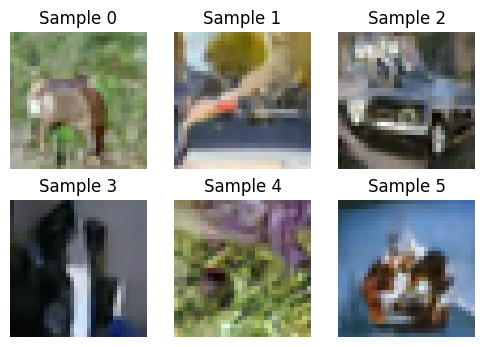

3125/3125 [==============================] - 873s 279ms/step - loss: 0.0311 - mean_absolute_error: 0.0947
Epoch 106/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.0938
Epoch 106: loss improved from 0.03060 to 0.03037, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.106-0.03.hdf5
3125/3125 [==============================] - 691s 221ms/step - loss: 0.0304 - mean_absolute_error: 0.0938
Epoch 107/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.0948
Epoch 107: loss did not improve from 0.03037
3125/3125 [==============================] - 690s 221ms/step - loss: 0.0311 - mean_absolute_error: 0.0948
Epoch 108/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0310 - mean_absolute_error: 0.0943
Epoch 108: loss did not improve from 0.03037
3125/3125 [==============================] - 690s 221ms/step - loss: 0.0310 - mean_absolute_error: 0.0943
Epoch 

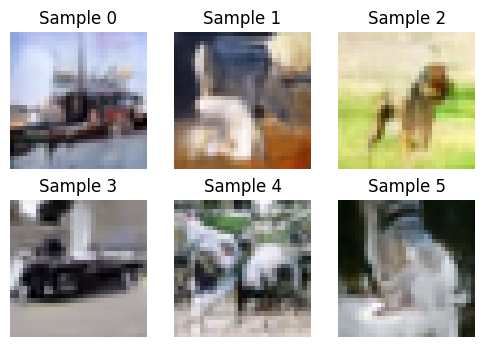

3125/3125 [==============================] - 867s 277ms/step - loss: 0.0308 - mean_absolute_error: 0.0940
Epoch 110/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.0943
Epoch 110: loss did not improve from 0.03037
3125/3125 [==============================] - 689s 221ms/step - loss: 0.0308 - mean_absolute_error: 0.0943
Epoch 111/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.0946
Epoch 111: loss did not improve from 0.03037
3125/3125 [==============================] - 689s 220ms/step - loss: 0.0311 - mean_absolute_error: 0.0946
Epoch 112/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0950
Epoch 112: loss did not improve from 0.03037
3125/3125 [==============================] - 691s 221ms/step - loss: 0.0313 - mean_absolute_error: 0.0950
Epoch 113/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 

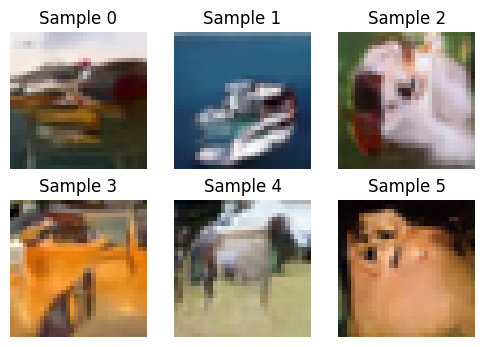

3125/3125 [==============================] - 869s 278ms/step - loss: 0.0301 - mean_absolute_error: 0.0933
Epoch 114/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.0938
Epoch 114: loss did not improve from 0.03011
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0308 - mean_absolute_error: 0.0938
Epoch 115/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.0941
Epoch 115: loss did not improve from 0.03011
3125/3125 [==============================] - 690s 221ms/step - loss: 0.0307 - mean_absolute_error: 0.0941
Epoch 116/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 0.0934
Epoch 118: loss did not improve from 0.03011
3125/3125 [==============================] - 690s 221ms/step - loss: 0.0301 - mean_absolute_error: 0.0934
Epoch 119/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 

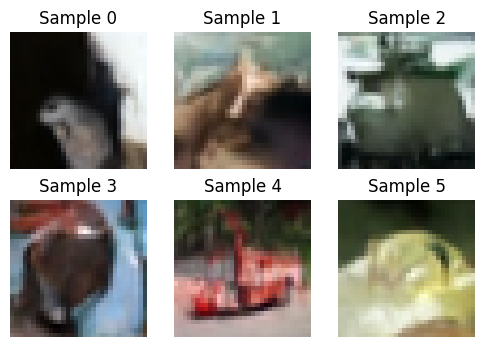

3125/3125 [==============================] - 870s 279ms/step - loss: 0.0304 - mean_absolute_error: 0.0933
Epoch 122/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.0935
Epoch 122: loss did not improve from 0.03011
3125/3125 [==============================] - 691s 221ms/step - loss: 0.0302 - mean_absolute_error: 0.0935
Epoch 123/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0305 - mean_absolute_error: 0.0937
Epoch 123: loss did not improve from 0.03011
3125/3125 [==============================] - 690s 221ms/step - loss: 0.0305 - mean_absolute_error: 0.0937
Epoch 124/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0942
Epoch 124: loss did not improve from 0.03011
3125/3125 [==============================] - 691s 221ms/step - loss: 0.0309 - mean_absolute_error: 0.0942
Epoch 125/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 

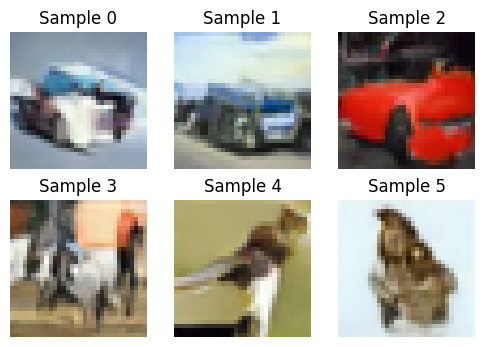

3125/3125 [==============================] - 871s 279ms/step - loss: 0.0302 - mean_absolute_error: 0.0931
Epoch 126/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.0937
Epoch 126: loss did not improve from 0.03011
3125/3125 [==============================] - 691s 221ms/step - loss: 0.0306 - mean_absolute_error: 0.0937
Epoch 127/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0943
Epoch 127: loss did not improve from 0.03011
3125/3125 [==============================] - 691s 221ms/step - loss: 0.0309 - mean_absolute_error: 0.0943
Epoch 128/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.0947
Epoch 128: loss did not improve from 0.03011
3125/3125 [==============================] - 691s 221ms/step - loss: 0.0312 - mean_absolute_error: 0.0947
Epoch 129/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 

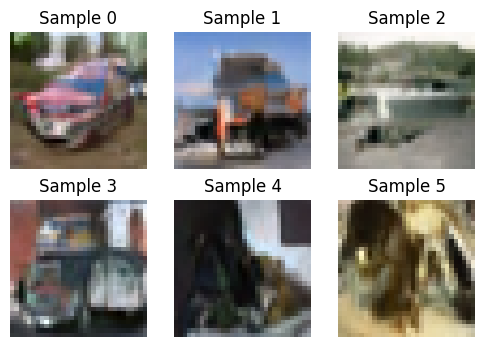

3125/3125 [==============================] - 871s 279ms/step - loss: 0.0304 - mean_absolute_error: 0.0939
Epoch 130/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.0940
Epoch 130: loss did not improve from 0.03011
3125/3125 [==============================] - 691s 221ms/step - loss: 0.0308 - mean_absolute_error: 0.0940
Epoch 131/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0936
Epoch 131: loss did not improve from 0.03011
3125/3125 [==============================] - 691s 221ms/step - loss: 0.0303 - mean_absolute_error: 0.0936
Epoch 132/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0310 - mean_absolute_error: 0.0945
Epoch 132: loss did not improve from 0.03011
3125/3125 [==============================] - 690s 221ms/step - loss: 0.0310 - mean_absolute_error: 0.0945
Epoch 133/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 

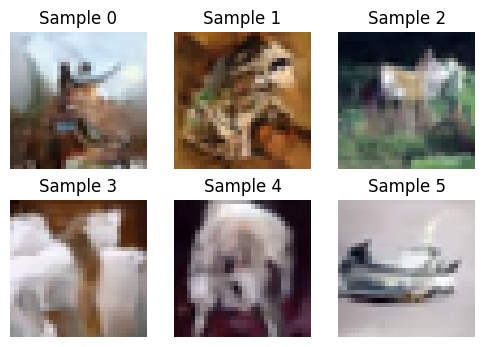

3125/3125 [==============================] - 873s 280ms/step - loss: 0.0303 - mean_absolute_error: 0.0935
Epoch 134/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0944
Epoch 134: loss did not improve from 0.03011
3125/3125 [==============================] - 691s 221ms/step - loss: 0.0309 - mean_absolute_error: 0.0944
Epoch 135/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0305 - mean_absolute_error: 0.0936
Epoch 135: loss did not improve from 0.03011
3125/3125 [==============================] - 691s 221ms/step - loss: 0.0305 - mean_absolute_error: 0.0936
Epoch 136/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.0939
Epoch 136: loss did not improve from 0.03011
3125/3125 [==============================] - 690s 221ms/step - loss: 0.0307 - mean_absolute_error: 0.0939
Epoch 137/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 

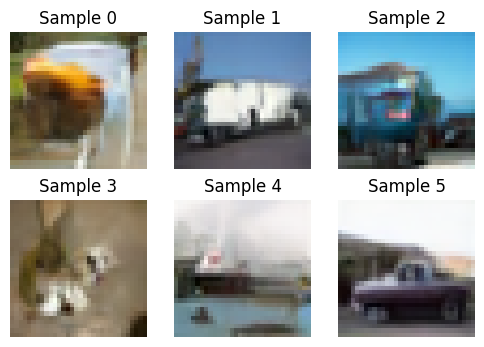

3125/3125 [==============================] - 871s 279ms/step - loss: 0.0302 - mean_absolute_error: 0.0933
Epoch 138/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.0932
Epoch 138: loss did not improve from 0.03011
3125/3125 [==============================] - 691s 221ms/step - loss: 0.0302 - mean_absolute_error: 0.0932
Epoch 139/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0934
Epoch 139: loss did not improve from 0.03011
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0303 - mean_absolute_error: 0.0934
Epoch 140/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.0925
Epoch 140: loss improved from 0.03011 to 0.02978, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.140-0.03.hdf5
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0298 - mean_absolute_error: 0.0925
Epoch 

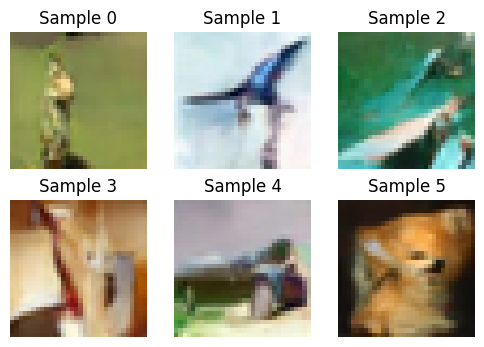

3125/3125 [==============================] - 879s 281ms/step - loss: 0.0305 - mean_absolute_error: 0.0935
Epoch 142/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.0940
Epoch 142: loss did not improve from 0.02978
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0308 - mean_absolute_error: 0.0940
Epoch 143/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0305 - mean_absolute_error: 0.0935
Epoch 143: loss did not improve from 0.02978
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0305 - mean_absolute_error: 0.0935
Epoch 144/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0310 - mean_absolute_error: 0.0945
Epoch 144: loss did not improve from 0.02978
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0310 - mean_absolute_error: 0.0945
Epoch 145/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 

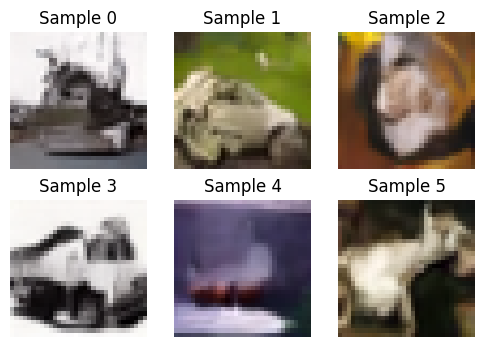

3125/3125 [==============================] - 872s 279ms/step - loss: 0.0308 - mean_absolute_error: 0.0942
Epoch 146/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.0938
Epoch 146: loss did not improve from 0.02978
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0306 - mean_absolute_error: 0.0938
Epoch 147/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.0945
Epoch 147: loss did not improve from 0.02978
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0312 - mean_absolute_error: 0.0945
Epoch 148/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0933
Epoch 148: loss did not improve from 0.02978
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0303 - mean_absolute_error: 0.0933
Epoch 149/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 

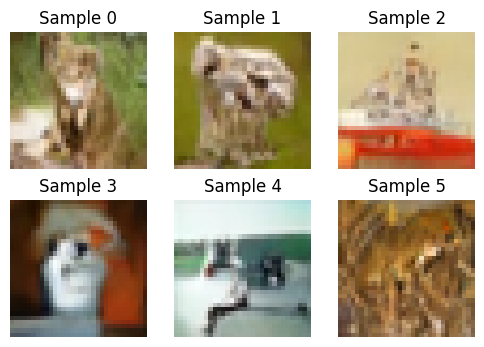

3125/3125 [==============================] - 874s 280ms/step - loss: 0.0304 - mean_absolute_error: 0.0935
Epoch 150/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0932
Epoch 150: loss did not improve from 0.02978
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0303 - mean_absolute_error: 0.0932
Epoch 151/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.0929
Epoch 151: loss did not improve from 0.02978
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0302 - mean_absolute_error: 0.0929
Epoch 152/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.0932
Epoch 152: loss did not improve from 0.02978
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0304 - mean_absolute_error: 0.0932
Epoch 153/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 

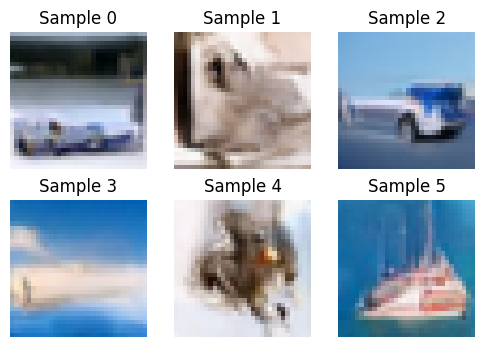

3125/3125 [==============================] - 879s 281ms/step - loss: 0.0309 - mean_absolute_error: 0.0941
Epoch 154/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0926
Epoch 154: loss did not improve from 0.02978
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0300 - mean_absolute_error: 0.0926
Epoch 155/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.0935
Epoch 155: loss did not improve from 0.02978
3125/3125 [==============================] - 692s 222ms/step - loss: 0.0306 - mean_absolute_error: 0.0935
Epoch 156/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0933
Epoch 156: loss did not improve from 0.02978
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0303 - mean_absolute_error: 0.0933
Epoch 157/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 

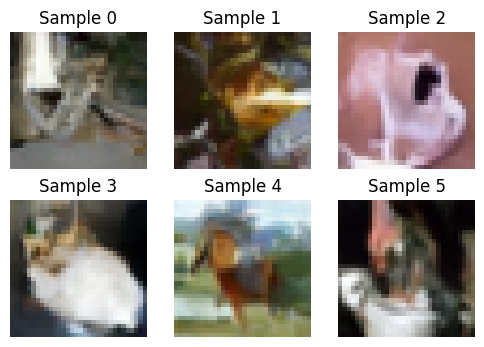

3125/3125 [==============================] - 882s 282ms/step - loss: 0.0308 - mean_absolute_error: 0.0938
Epoch 158/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.0924
Epoch 158: loss improved from 0.02978 to 0.02958, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.158-0.03.hdf5
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0296 - mean_absolute_error: 0.0924
Epoch 159/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.0935
Epoch 159: loss did not improve from 0.02958
3125/3125 [==============================] - 692s 222ms/step - loss: 0.0307 - mean_absolute_error: 0.0935
Epoch 160/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 0.0929
Epoch 160: loss did not improve from 0.02958
3125/3125 [==============================] - 694s 222ms/step - loss: 0.0301 - mean_absolute_error: 0.0929
Epoch 

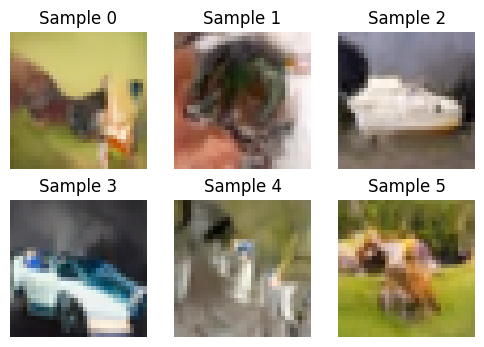

3125/3125 [==============================] - 877s 281ms/step - loss: 0.0308 - mean_absolute_error: 0.0937
Epoch 162/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0310 - mean_absolute_error: 0.0940
Epoch 162: loss did not improve from 0.02958
3125/3125 [==============================] - 693s 222ms/step - loss: 0.0310 - mean_absolute_error: 0.0940
Epoch 163/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.0937
Epoch 163: loss did not improve from 0.02958
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0306 - mean_absolute_error: 0.0937
Epoch 164/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0305 - mean_absolute_error: 0.0933
Epoch 164: loss did not improve from 0.02958
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0305 - mean_absolute_error: 0.0933
Epoch 165/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 

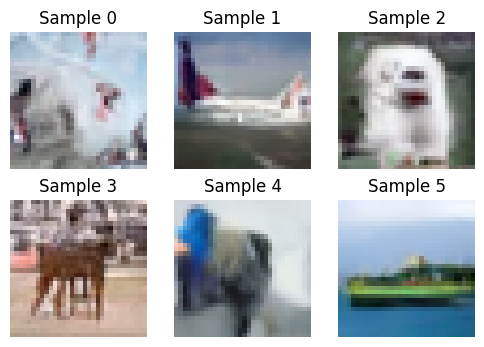

3125/3125 [==============================] - 875s 280ms/step - loss: 0.0306 - mean_absolute_error: 0.0935
Epoch 166/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.0934
Epoch 166: loss did not improve from 0.02958
3125/3125 [==============================] - 692s 222ms/step - loss: 0.0304 - mean_absolute_error: 0.0934
Epoch 167/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.0934
Epoch 167: loss did not improve from 0.02958
3125/3125 [==============================] - 692s 222ms/step - loss: 0.0302 - mean_absolute_error: 0.0934
Epoch 168/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.0929
Epoch 168: loss did not improve from 0.02958
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0302 - mean_absolute_error: 0.0929
Epoch 169/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0305 - mean_absolute_error: 

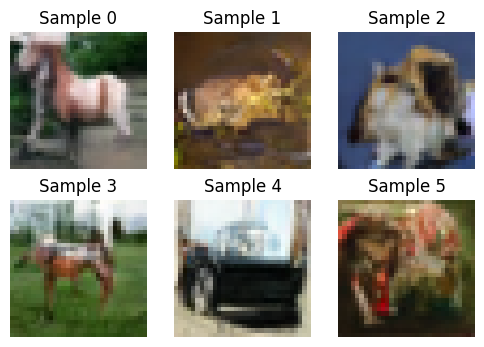

3125/3125 [==============================] - 874s 280ms/step - loss: 0.0305 - mean_absolute_error: 0.0935
Epoch 170/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.0927
Epoch 170: loss did not improve from 0.02958
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0299 - mean_absolute_error: 0.0927
Epoch 171/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 0.0930
Epoch 171: loss did not improve from 0.02958
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0301 - mean_absolute_error: 0.0930
Epoch 172/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0927
Epoch 172: loss did not improve from 0.02958
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0303 - mean_absolute_error: 0.0927
Epoch 173/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 

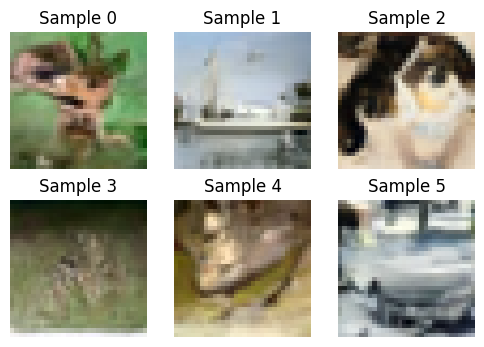

3125/3125 [==============================] - 875s 280ms/step - loss: 0.0302 - mean_absolute_error: 0.0929
Epoch 174/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.0931
Epoch 174: loss did not improve from 0.02958
3125/3125 [==============================] - 692s 222ms/step - loss: 0.0304 - mean_absolute_error: 0.0931
Epoch 175/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.0934
Epoch 175: loss did not improve from 0.02958
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0304 - mean_absolute_error: 0.0934
Epoch 176/200
3125/3125 [==============================] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 0.0928
Epoch 176: loss did not improve from 0.02958
3125/3125 [==============================] - 692s 221ms/step - loss: 0.0301 - mean_absolute_error: 0.0928
Epoch 177/200
 350/3125 [==>...........................] - ETA: 10:14 - loss: 0.0314 - mean_absolute_erro

In [ ]:
diffuser.fit(
    train_dataset,
    epochs=200,
    verbose=1,
    callbacks=[checkpoint_callback, synthesis_callback],
    initial_epoch=65,
    steps_per_epoch=STEPS_PER_EPOCH,
)

In [ ]:
images = diffuser.generative_process(
    sampling_size=10, label=tf.range(10), output_trajectory=False, verbose=1
)

fig = plt.figure(figsize=(5 * 3, 5 * 3))

for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title(f"Class {i}: {class_mapping[i]}")
    plt.imshow(
        tf.keras.preprocessing.image.array_to_img(
            images[i], data_format="channels_last"
        )
    )
    plt.axis("off")
plt.show()

# Previous runs:

## Last epoch completed : 71
## Last checkpoint epoch : 65

Epoch 56/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0964
Epoch 56: loss improved from inf to 0.03167, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.56-0.03.hdf5
3125/3125 [==============================] - 727s 225ms/step - loss: 0.0317 - mean_absolute_error: 0.0964
Epoch 57/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0973
Epoch 57: loss did not improve from 0.03167

Epoch 57: generating 6 samples with labels [5 2 3 8 3 6]
1000/1000 [==============================] - 191s 190ms/step


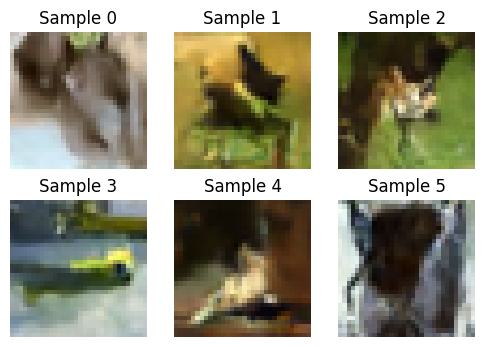

3125/3125 [==============================] - 894s 286ms/step - loss: 0.0324 - mean_absolute_error: 0.0973
Epoch 58/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.0964
Epoch 58: loss did not improve from 0.03167
3125/3125 [==============================] - 703s 225ms/step - loss: 0.0319 - mean_absolute_error: 0.0964
Epoch 59/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.0967
Epoch 59: loss did not improve from 0.03167
3125/3125 [==============================] - 703s 225ms/step - loss: 0.0320 - mean_absolute_error: 0.0967
Epoch 60/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0958
Epoch 60: loss improved from 0.03167 to 0.03138, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.60-0.03.hdf5
3125/3125 [==============================] - 703s 225ms/step - loss: 0.0314 - mean_absolute_error: 0.0958
Epoch 61/100


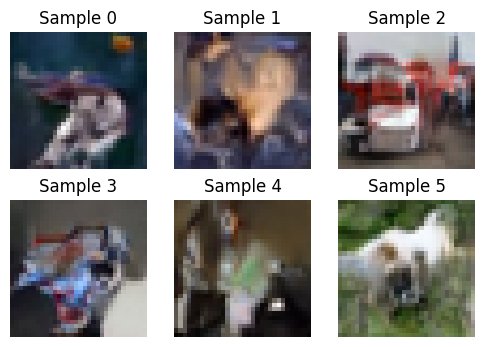

3125/3125 [==============================] - 890s 285ms/step - loss: 0.0322 - mean_absolute_error: 0.0969
Epoch 62/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.0970
Epoch 62: loss did not improve from 0.03138
3125/3125 [==============================] - 701s 224ms/step - loss: 0.0319 - mean_absolute_error: 0.0970
Epoch 63/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0958
Epoch 63: loss did not improve from 0.03138
3125/3125 [==============================] - 703s 225ms/step - loss: 0.0314 - mean_absolute_error: 0.0958
Epoch 64/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0965
Epoch 64: loss did not improve from 0.03138
3125/3125 [==============================] - 701s 224ms/step - loss: 0.0317 - mean_absolute_error: 0.0965
Epoch 65/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0954


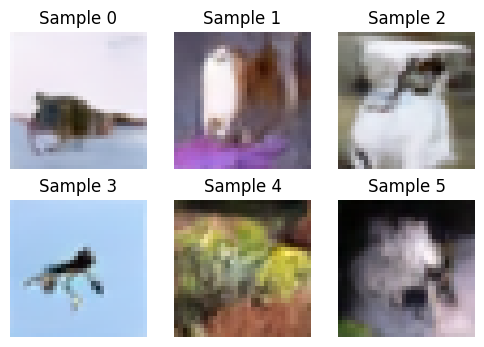

3125/3125 [==============================] - 887s 284ms/step - loss: 0.0313 - mean_absolute_error: 0.0954
Epoch 66/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.0967
Epoch 66: loss did not improve from 0.03127
3125/3125 [==============================] - 701s 224ms/step - loss: 0.0320 - mean_absolute_error: 0.0967
Epoch 67/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0961
Epoch 67: loss did not improve from 0.03127
3125/3125 [==============================] - 700s 224ms/step - loss: 0.0316 - mean_absolute_error: 0.0961
Epoch 68/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0959
Epoch 68: loss did not improve from 0.03127
3125/3125 [==============================] - 700s 224ms/step - loss: 0.0316 - mean_absolute_error: 0.0959
Epoch 69/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0318 - mean_absolute_error: 0.0962


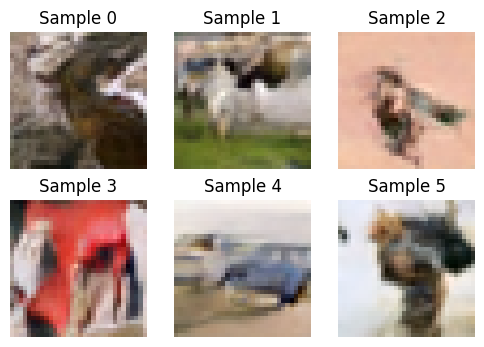

3125/3125 [==============================] - 886s 283ms/step - loss: 0.0318 - mean_absolute_error: 0.0962
Epoch 70/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.0969
Epoch 70: loss did not improve from 0.03127
3125/3125 [==============================] - 704s 225ms/step - loss: 0.0323 - mean_absolute_error: 0.0969
Epoch 71/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0960
Epoch 71: loss did not improve from 0.03127
3125/3125 [==============================] - 703s 225ms/step - loss: 0.0317 - mean_absolute_error: 0.0960
Epoch 72/100
 362/3125 [==>...........................] - ETA: 10:21 - loss: 0.0322 - mean_absolute_error: 0.0964

In [ ]:
diffuser.fit(
    train_dataset,
    epochs=100,
    verbose=1,
    callbacks=[checkpoint_callback, synthesis_callback],
    initial_epoch=55,
    steps_per_epoch=STEPS_PER_EPOCH,
)

## Last epoch completed : 56
## Last checkpoint epoch : 55

Epoch 1/100


2023-03-15 21:43:22.202302: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


3125/3125 [==============================] - ETA: 0s - loss: 0.1187 - mean_absolute_error: 0.2293
Epoch 1: loss improved from inf to 0.11873, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.01-0.12.hdf5

Epoch 1: generating 6 samples with labels [3 3 6 7 5 3]
1000/1000 [==============================] - 228s 227ms/step


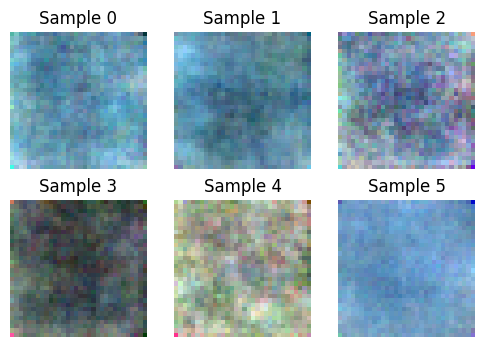

3125/3125 [==============================] - 959s 298ms/step - loss: 0.1187 - mean_absolute_error: 0.2293
Epoch 2/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0561 - mean_absolute_error: 0.1513
Epoch 2: loss improved from 0.11873 to 0.05612, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.02-0.06.hdf5
3125/3125 [==============================] - 703s 225ms/step - loss: 0.0561 - mean_absolute_error: 0.1513
Epoch 3/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0484 - mean_absolute_error: 0.1362
Epoch 3: loss improved from 0.05612 to 0.04836, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.03-0.05.hdf5
3125/3125 [==============================] - 703s 225ms/step - loss: 0.0484 - mean_absolute_error: 0.1362
Epoch 4/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0456 - mean_absolute_error: 0.1291
Epoch 4: loss improved from 0.04836 to 0.04559, saving model to /home/

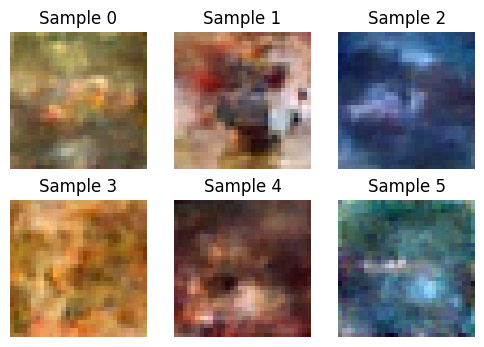

3125/3125 [==============================] - 908s 290ms/step - loss: 0.0437 - mean_absolute_error: 0.1247
Epoch 6/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.1209
Epoch 6: loss improved from 0.04373 to 0.04194, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.06-0.04.hdf5
3125/3125 [==============================] - 701s 224ms/step - loss: 0.0419 - mean_absolute_error: 0.1209
Epoch 7/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0409 - mean_absolute_error: 0.1182
Epoch 7: loss improved from 0.04194 to 0.04087, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.07-0.04.hdf5
3125/3125 [==============================] - 701s 224ms/step - loss: 0.0409 - mean_absolute_error: 0.1182
Epoch 8/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.1150
Epoch 8: loss improved from 0.04087 to 0.03946, saving model to /home/

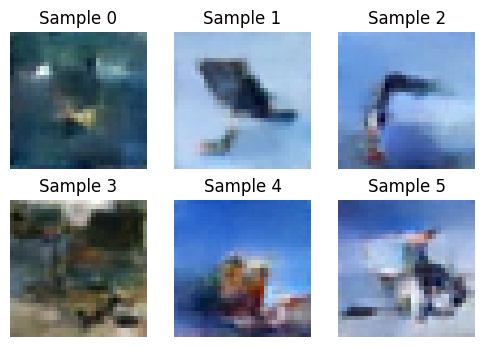

3125/3125 [==============================] - 907s 290ms/step - loss: 0.0394 - mean_absolute_error: 0.1141
Epoch 10/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.1114
Epoch 10: loss improved from 0.03939 to 0.03777, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.10-0.04.hdf5
3125/3125 [==============================] - 700s 224ms/step - loss: 0.0378 - mean_absolute_error: 0.1114
Epoch 11/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.1113
Epoch 11: loss did not improve from 0.03777
3125/3125 [==============================] - 700s 224ms/step - loss: 0.0382 - mean_absolute_error: 0.1113
Epoch 12/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.1090
Epoch 12: loss improved from 0.03777 to 0.03692, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.12-0.04.hdf5
3125/3125 [==========

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3125/3125 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.1013
Epoch 26: loss improved from 0.03382 to 0.03374, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.26-0.03.hdf5
3125/3125 [==============================] - 699s 224ms/step - loss: 0.0337 - mean_absolute_error: 0.1013
Epoch 27/100
 560/3125 [====>.........................] - ETA: 9:34 - loss: 0.0339 - mean_absolute_error: 0.1019

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3125/3125 [==============================] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0998
Epoch 33: loss did not improve from 0.03308

Epoch 33: generating 6 samples with labels [3 0 2 9 3 3]
1000/1000 [==============================] - 205s 204ms/step


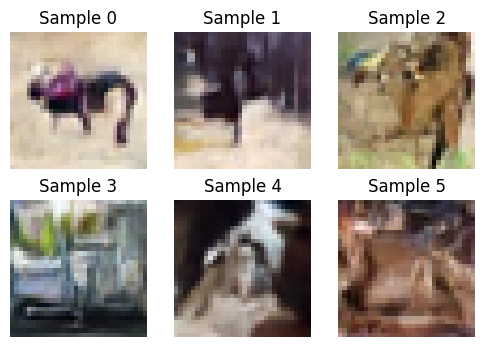

3125/3125 [==============================] - 904s 289ms/step - loss: 0.0332 - mean_absolute_error: 0.0998
Epoch 34/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0982
Epoch 42: loss improved from 0.03253 to 0.03242, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.42-0.03.hdf5
3125/3125 [==============================] - 701s 224ms/step - loss: 0.0324 - mean_absolute_error: 0.0982
Epoch 43/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.0985
Epoch 43: loss did not improve from 0.03242
3125/3125 [==============================] - 702s 225ms/step - loss: 0.0327 - mean_absolute_error: 0.0985
Epoch 44/100
 638/3125 [=====>........................] - ETA: 9:17 - loss: 0.0333 - mean_absolute_error: 0.0988

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3125/3125 [==============================] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.0981
Epoch 44: loss did not improve from 0.03242
3125/3125 [==============================] - 702s 225ms/step - loss: 0.0325 - mean_absolute_error: 0.0981
Epoch 45/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0979
Epoch 45: loss did not improve from 0.03242

Epoch 45: generating 6 samples with labels [5 1 4 1 1 7]
1000/1000 [==============================] - 212s 212ms/step


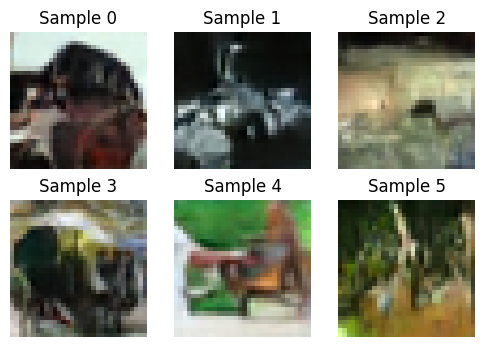

3125/3125 [==============================] - 915s 293ms/step - loss: 0.0324 - mean_absolute_error: 0.0979
Epoch 46/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.0981
Epoch 46: loss did not improve from 0.03242
3125/3125 [==============================] - 703s 225ms/step - loss: 0.0326 - mean_absolute_error: 0.0981
Epoch 47/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.0981
Epoch 47: loss did not improve from 0.03242
3125/3125 [==============================] - 704s 225ms/step - loss: 0.0326 - mean_absolute_error: 0.0981
Epoch 48/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0982
Epoch 48: loss did not improve from 0.03242
3125/3125 [==============================] - 704s 225ms/step - loss: 0.0329 - mean_absolute_error: 0.0982
Epoch 49/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0321 - mean_absolute_error: 0.0975


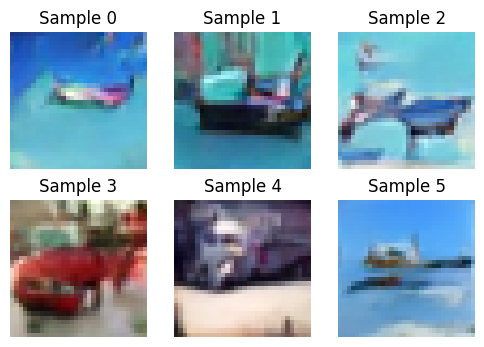

3125/3125 [==============================] - 911s 292ms/step - loss: 0.0321 - mean_absolute_error: 0.0975
Epoch 50/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.0972
Epoch 50: loss improved from 0.03213 to 0.03199, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.50-0.03.hdf5
3125/3125 [==============================] - 703s 225ms/step - loss: 0.0320 - mean_absolute_error: 0.0972
Epoch 51/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.0976
Epoch 51: loss did not improve from 0.03199
3125/3125 [==============================] - 703s 225ms/step - loss: 0.0323 - mean_absolute_error: 0.0976
Epoch 52/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.0974
Epoch 52: loss did not improve from 0.03199
3125/3125 [==============================] - 703s 225ms/step - loss: 0.0323 - mean_absolute_error: 0.0974
Epoch 53/100


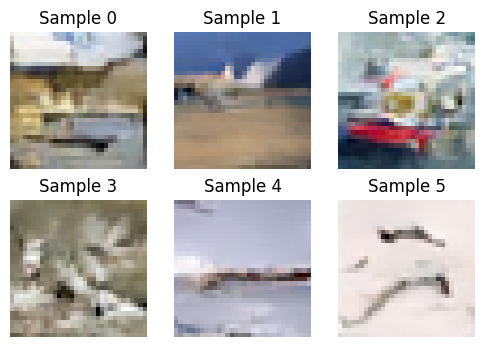

3125/3125 [==============================] - 914s 293ms/step - loss: 0.0323 - mean_absolute_error: 0.0973
Epoch 54/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.0977
Epoch 54: loss did not improve from 0.03199
3125/3125 [==============================] - 702s 225ms/step - loss: 0.0327 - mean_absolute_error: 0.0977
Epoch 55/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0962
Epoch 55: loss improved from 0.03199 to 0.03173, saving model to /home/jupyter/instance_registry/cifar10_diffuser/ckpt_1_weights.55-0.03.hdf5
3125/3125 [==============================] - 704s 225ms/step - loss: 0.0317 - mean_absolute_error: 0.0962
Epoch 56/100
3125/3125 [==============================] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.0966
Epoch 56: loss did not improve from 0.03173
3125/3125 [==============================] - 702s 224ms/step - loss: 0.0319 - mean_absolute_error: 0.0966
Epoch 57/100


In [ ]:
diffuser.fit(
    train_dataset,
    epochs=100,
    callbacks=[checkpoint_callback, synthesis_callback],
    steps_per_epoch=STEPS_PER_EPOCH,
)